# Paper

Test of the paper given to us from professor

In [ ]:
# Test of the paper 
import pywt
import statistics
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
from math import floor

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def highResDetector(l, theta):
    if theta == 1:      # in case we are passing HH
        theta = sqrt(2)
    else:               # in all the other cases
        theta = 1
    
    if l == 0:          # in the first  pass of DWT
        l = 1
    else:               # in all the other passes
        l = 0.32
    return theta * l

def lightness (l, i, j, LL3):
    #res = (1/256) * (1 + floor(LL3[i,j] / pow(2, 3 - l)))
    new_i = floor(i / pow(2, 3 - l))
    new_j = floor(j / pow(2, 3 - l))
    
    res = (1/256) * LL3[new_i,new_j]
    if res > 0.5:
        return res
    else:
        return 1 - res

def brigtnessDetector(l, i, j, LL3):
    return 1 + lightness(l, i, j, LL3)

def textureDetector(l, i, j, LL3, dwtMatrix):
    res = 0
    for k in range(0, 4 - l, 1):
        met = 0
        for theta in range (3):
            for x in range(2):
                for y in range(2):
                    new_x = y + ( i // pow(2 ,k))
                    new_y = x + ( j // pow(2 ,k))
                    met += pow(dwtMatrix[k+l][theta][new_x][new_y] , 2) 
        res +=  1 / pow(16, k) * met 
    

    data = []
    for x in range(2):
        for y in range(2):
            new_x = 1 + y + ( i//pow(2,3-l))
            new_y = 1 + x + ( j//pow(2,3-l))
            data.append(LL3[new_x,new_y])
    
    res *= statistics.pvariance(data)
    return res


def quantization(l, theta, i, j, LL3, dwtMatrix):
    return highResDetector(l, theta) * brigtnessDetector(l, i, j, LL3) * textureDetector(l,i,j,LL3,dwtMatrix)

def mask(l, theta, i, j, LL3,dwtMatrix):
    return quantization(l, theta, i, j, LL3,dwtMatrix) / 2

def embedding(image, mark_size, alpha, v='modular'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    coeffs3 = pywt.dwt2(LL, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3
    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5
    dwtMatrix = [[HL,HH,LH,LL],[HL1,HH1,LH1,LL1],[HL2,HH2,LH2,LL2],[HL3,HH3,LH3,LL3]]

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 0
            x = locations_LH[idx][0]
            y = locations_LH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val) 
    
     # Embed the watermark in HL
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 2
            x = locations_HL[idx][0]
            y = locations_HL[idx][1]
            watermarked_HL[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)
        elif v == 'modular':
            l = 0
            theta = 1
            x = locations_HH[idx][0]
            y = locations_HH[idx][1]
            watermarked_LH[loc] += (alpha * mask(l, theta, x, y, LL3, dwtMatrix) * mark_val)  

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(20, 20))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'modular'
alpha = 0.9
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)


#######  your attack  ########

attacked = awgn(watermarked1, 20, 123)


plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


# Error correction codes

Test different error correction codes

## Hamming(7,4)

In [4]:
def calculate_parity_bits(data_bits):
    """Calculate the parity bits for a 4-bit data message."""
    p1 = data_bits[0] ^ data_bits[1] ^ data_bits[3]  # Parity for bits 1, 3, 5, 7
    p2 = data_bits[0] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 2, 3, 6, 7
    p3 = data_bits[1] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 4, 5, 6, 7
    return [p1, p2, p3]

def hamming_encode(data_bits):
    """Encode 4 data bits into a 7-bit Hamming (7,4) code."""
    if len(data_bits) != 4:
        raise ValueError("Input must be a list of 4 data bits.")
    
    # Calculate parity bits
    p1, p2, p3 = calculate_parity_bits(data_bits)
    
    # Arrange the codeword: [p1, p2, data1, p3, data2, data3, data4]
    codeword = [p1, p2, data_bits[0], p3, data_bits[1], data_bits[2], data_bits[3]]
    
    return codeword

def split_into_blocks(bit_string, block_size=4):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def encode_1024_bit_string(bit_string):
    """Encode a 1024-bit string using Hamming (7,4) encoding in blocks of 4 bits."""
    if len(bit_string) != 1024:
        raise ValueError("Input string must be exactly 1024 bits long.")
    
    # Split the bit string into 4-bit blocks
    blocks = split_into_blocks(bit_string, 4)
    
    # Prepare to store the encoded blocks
    encoded_blocks = []
    
    # Encode each 4-bit block using Hamming (7,4)
    for block in blocks:
        # Convert each 4-bit block (string) into a list of integers
        data_bits = [int(bit) for bit in block]
        
        # Encode the block and add the resulting 7-bit codeword to encoded_blocks
        encoded_blocks.append(hamming_encode(data_bits))
    
    # Flatten the list of encoded blocks into a single list of bits
    encoded_bits = [bit for block in encoded_blocks for bit in block]
    
    # Convert the list of bits into a string
    encoded_string = ''.join(map(str, encoded_bits))
    
    return encoded_string

# Example usage:
bit_string = '110101011010' * 85 + '0' * 4  # Example 1024-bit string (repeated pattern)
encoded_result = encode_1024_bit_string(bit_string)
print(type(encoded_result))

print(f"Original 1024-bit string: {bit_string[:60]}...")  # Print a small portion for brevity
print(f"Encoded string (7,4 Hamming blocks): {encoded_result[:105]}...")  # Print a small portion for brevity
print(f"Encoded length: {len(encoded_result)} bits")


<class 'str'>
Original 1024-bit string: 110101011010110101011010110101011010110101011010110101011010...
Encoded string (7,4 Hamming blocks): 101010101001011011010101010101001011011010101010101001011011010101010101001011011010101010101001011011010...
Encoded length: 1792 bits


In [ ]:
def hamming_decode(codeword):
    """Decode the 7-bit Hamming code, correct single-bit errors, and extract the original 4 data bits."""
    if len(codeword) != 7:
        raise ValueError("Codeword must be 7 bits long.")
    
    # Extract the parity and data bits
    p1, p2, d1, p3, d2, d3, d4 = codeword
    
    # Recalculate the parity bits based on the received data
    c1 = p1 ^ d1 ^ d2 ^ d4  # Check parity bit 1
    c2 = p2 ^ d1 ^ d3 ^ d4  # Check parity bit 2
    c3 = p3 ^ d2 ^ d3 ^ d4  # Check parity bit 3
    
    # Combine the parity check results into a single error syndrome
    error_position = (c3 << 2) | (c2 << 1) | c1  # Binary value gives error position
    
    # If error_position is non-zero, correct the error
    if error_position != 0:
        print(f"Error detected at position {error_position}. Correcting...")
        codeword[error_position - 1] ^= 1  # Flip the bit at the error position
    
    # Extract the original data bits from the corrected codeword
    data_bits = [codeword[2], codeword[4], codeword[5], codeword[6]]
    
    return data_bits

def split_into_blocks(bit_string, block_size):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def decode_1792_bit_string(encoded_string):
    """Decode a 1792-bit Hamming (7,4) encoded string back into a 1024-bit string."""
    if len(encoded_string) != 1792:
        raise ValueError("Input string must be exactly 1792 bits long.")
    
    # Split the encoded string into 7-bit blocks
    encoded_blocks = split_into_blocks(encoded_string, 7)
    
    # Prepare to store the decoded data bits
    decoded_data_bits = []
    
    # Decode each 7-bit block and extract the original 4 data bits
    for block in encoded_blocks:
        # Convert the 7-bit block (string) into a list of integers
        codeword = [int(bit) for bit in block]
        
        # Decode the block to get the original 4 data bits
        decoded_bits = hamming_decode(codeword)
        
        # Append the decoded 4 data bits to the result
        decoded_data_bits.extend(decoded_bits)
    
    # Convert the list of decoded data bits into a string
    decoded_string = ''.join(map(str, decoded_data_bits))
    
    return decoded_string

# Example usage:
encoded_string = encoded_result
print(type(encoded_string))
decoded_result = decode_1792_bit_string(encoded_string)

print(f"Decoded 1024-bit string: {decoded_result[:60]}...")  # Print a small portion for brevity
print(f"Decoded length: {len(decoded_result)} bits")
print(decoded_result == bit_string)


### Findings

Ok code allow only one error per block 

## LDPC

In [ ]:
!pip install --upgrade pyldpc

In [ ]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message
n = 2048
d_v = 4
d_c = 8
snr = 20
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
markExtended = np.append(mark, [0, 0, 0])
y = encode(G, markExtended, snr)


for _ in range(4096):
    y[np.random.randint(0, 2048)] = np.random.randint(0, 1)


d = decode(H, y, snr, maxiter=100)
x = get_message(G, d)
markExtracted = np.delete(x, np.s_[-3:])
print(abs(mark - markExtracted).sum() == 0)
print(similarity(mark, markExtracted))

# n = 2040, k = 1023
# n = 2048, k = 1027

## Solomon codes

Test for solomon codes to have more correction per block

In [ ]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'common'))
from fieldmath import Field, Matrix  # Ensure this matches the classes defined in fieldmath.py
from reed_solomon import ReedSolomon

# Create a finite field (for example, GF(255))
field = Field(255)

# Initialize Reed-Solomon encoder/decoder
msg_length = 10  # Number of message symbols
ecc_length = 5   # Number of error correction symbols
generator = 2    # A primitive element of the field

rs = ReedSolomon(field, generator, msg_length, ecc_length)

# Example message to encode
message = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Encode the message
codeword = rs.encode(message)

print("Encoded Codeword:", codeword)

# Introduce some errors in the codeword for testing
codeword_with_errors = codeword.copy()
codeword_with_errors[3] = 255  # Introducing an error
codeword_with_errors[7] = 255  # Introducing another error

# Decode the codeword
decoded_message = rs.decode(codeword_with_errors)

print("Decoded Message:", decoded_message)


### Findings 

Very good performance but too slow to converge for the chall

In [ ]:
!pip install tdqm

# Embeddings

Series of different embeddings

## SS using DWT

Using spread spectrum and embedding on the frequency obtainded by the DWT transformed from layer 0 (the tuple reslulted from the first transformed) to layer 2

### DWT using perceptual mask

Modular function that can embed on layer 0 to 2 with different alphas depending on the layer and the fetures in the image

In [ ]:
from pyldpc import make_ldpc, encode, decode, get_message
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
import sys
sys.path.append(os.path.join(os.getcwd(), 'common'))
import attacks

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))

def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask += compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            # extracted_mark[idx] = ((watermarked_subband[loc] / subband[loc]) - 1) / (modular_alpha(layer, theta, alpha) * mask[x][y])
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc]


        
    return  np.clip(extracted_mark, 0, 1).astype(np.uint8)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []

    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms

def detection(original, watermarked, attacked, alpha, max_layer):
    w_ex = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    w_ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    thr = 0.7045
    sim = []
    
    ex_mark = w_ex[0]
    
    for w in w_ex_attacked:
        x = similarity(w, ex_mark)
        sim.append(x)
    
    sim = max(sim)

    print(sim)
    print(similarity(ex_mark,mark))

    if sim >= thr:
        return 1
    return 0




imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')

alpha = 0.35
img = cv2.imread('lena_grey.bmp', 0)
wm = embedding(img, mark, alpha, 2)


attacked = wm


plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(wm, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

is_wm = detection(img, wm, attacked, alpha, 2)

if is_wm:
    print("found")
else:
    print("not found")

print(wpsnr(wm, img))
print(wpsnr(wm, attacked))


### DWT using perceptual mask and Hamming(7,4)

Modular function that can embed on layer 0 to 2 with different alphas depending on the layer and the fetures in the image. As for error correction it used Hamming(7,4)

/tmp/ipykernel_3385/3662816074.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


[array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.72942771e-14, 0.00000000e+00, 1.00000000e+00]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       5.69050357e-14, 3.52767041e-14, 1.00000000e+00]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       5.80732409e-14, 3.60525569e-14, 1.00000000e+00])]
3
[array([0.03312441, 0.        , 0.08194416, ..., 0.33333333, 0.33333333,
       0.33333333]), array([0.03312441, 0.        , 0.08194416, ..., 0.33333333, 0.33333333,
       0.33333333]), array([0.03312441, 0.        , 0.08194416, ..., 0.33333333, 0.33333333,
       0.33333333])]
3
Similarity between original and extracted mark:  0.6572459811414633
not found
58.34167746078293
49.2980924419743


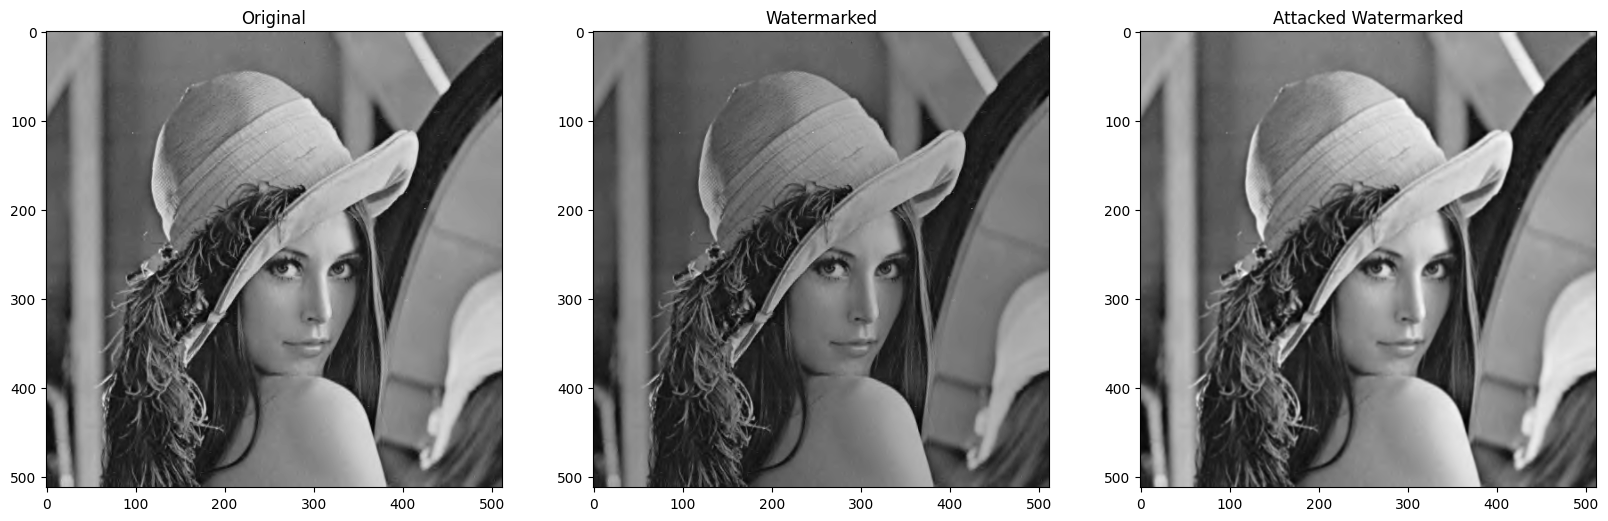

In [17]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt


def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X, X_star):
    # Computes the similarity measure between the original and the new watermarks.
    norm_X = np.sqrt(np.sum(np.multiply(X, X)))
    norm_X_star = np.sqrt(np.sum(np.multiply(X_star, X_star)))

    if norm_X == 0 or norm_X_star == 0:
        return 0.0  # or return 0 or another appropriate value

    s = np.sum(np.multiply(X, X_star)) / (norm_X * norm_X_star)
    return s

def compute_thr(sim, mark, mark_size=1024, N=1000):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(mark, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

def calculate_parity_bits(data_bits):
    """Calculate the parity bits for a 4-bit data message."""
    p1 = data_bits[0] ^ data_bits[1] ^ data_bits[3]  # Parity for bits 1, 3, 5, 7
    p2 = data_bits[0] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 2, 3, 6, 7
    p3 = data_bits[1] ^ data_bits[2] ^ data_bits[3]  # Parity for bits 4, 5, 6, 7
    return [p1, p2, p3]

def hamming_encode(data_bits):
    """Encode 4 data bits into a 7-bit Hamming (7,4) code."""
    if len(data_bits) != 4:
        raise ValueError("Input must be a list of 4 data bits.")
    
    # Calculate parity bits
    p1, p2, p3 = calculate_parity_bits(data_bits)
    
    # Arrange the codeword: [p1, p2, data1, p3, data2, data3, data4]
    codeword = [p1, p2, data_bits[0], p3, data_bits[1], data_bits[2], data_bits[3]]
    
    return codeword

def split_into_blocks(bit_string, block_size=4):
    """Split the bit string into blocks of size block_size."""
    return [bit_string[i:i + block_size] for i in range(0, len(bit_string), block_size)]

def encode_1024_bit_string(bit_string):
    """Encode a 1024-bit string using Hamming (7,4) encoding in blocks of 4 bits."""
    if len(bit_string) != 1024:
        raise ValueError("Input string must be exactly 1024 bits long.")
    
    # Split the bit string into 4-bit blocks
    blocks = split_into_blocks(bit_string, 4)
    
    # Prepare to store the encoded blocks
    encoded_blocks = []
    
    # Encode each 4-bit block using Hamming (7,4)
    for block in blocks:
        # Convert each 4-bit block (string) into a list of integers
        data_bits = [int(bit) for bit in block]
        
        # Encode the block and add the resulting 7-bit codeword to encoded_blocks
        encoded_blocks.append(hamming_encode(data_bits))
    
    # Flatten the list of encoded blocks into a single list of bits
    encoded_bits = [bit for block in encoded_blocks for bit in block]
    
    # Convert the list of bits into a string
    # encoded_string = ''.join(map(str, encoded_bits))
    
    return encoded_bits

def hamming_decode(codeword):
    """Decode the 7-bit Hamming code, correct single-bit errors, and extract the original 4 data bits."""
    if len(codeword) != 7:
        raise ValueError("Codeword must be 7 bits long.")
    
    # Extract the parity and data bits
    p1, p2, d1, p3, d2, d3, d4 = codeword
    
    # Recalculate the parity bits based on the received data
    c1 = p1 ^ d1 ^ d2 ^ d4  # Check parity bit 1
    c2 = p2 ^ d1 ^ d3 ^ d4  # Check parity bit 2
    c3 = p3 ^ d2 ^ d3 ^ d4  # Check parity bit 3
    
    # Combine the parity check results into a single error syndrome
    error_position = (c3 << 2) | (c2 << 1) | c1  # Binary value gives error position
    
    # If error_position is non-zero, correct the error
    if error_position != 0:
        codeword[error_position - 1] ^= 1  # Flip the bit at the error position
    
    # Extract the original data bits from the corrected codeword
    data_bits = [codeword[2], codeword[4], codeword[5], codeword[6]]
    
    return data_bits


def decode_1792_bit_string(encoded_array):
    """Decode a 1792-bit Hamming (7,4) encoded string back into a 1024-bit string."""
    encoded_string = ''.join(map(str, encoded_array))
    print(len(encoded_string))
    if len(encoded_string) != 1792:
        raise ValueError("Input string must be exactly 1792 bits long.")
    
    # Split the encoded string into 7-bit blocks
    encoded_blocks = split_into_blocks(encoded_string, 7)
    
    # Prepare to store the decoded data bits
    decoded_data_bits = []
    
    # Decode each 7-bit block and extract the original 4 data bits
    for block in encoded_blocks:
        # Convert the 7-bit block (string) into a list of integers
        codeword = [int(bit) for bit in block]
        
        # Decode the block to get the original 4 data bits
        decoded_bits = hamming_decode(codeword)
        
        # Append the decoded 4 data bits to the result
        decoded_data_bits.extend(decoded_bits)
    
    # Convert the list of decoded data bits into a string
    decoded_string = ''.join(map(str, decoded_data_bits))
    
    return decoded_string


def create_perceptual_mask(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobel_x, sobel_y)
    mask = cv2.normalize(edges, None, 0, 1, cv2.NORM_MINMAX)
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # calculate encoded watermark
    encoded_watermark = encode_1024_bit_string(mark)
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, encoded_watermark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc])
        
    return np.clip(extracted_mark, 0, 1)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []
    w_ex = []
    if max_layer == 2:
        # encoded_string = ''.join(map(str, encoded_bits))
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
        w_ex.append(np.clip((sum(extracted_wms) / 3), 0, 1))

    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))
        w_ex.append(np.clip((sum(extracted_wms) / 3), 0, 1))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))
    w_ex.append(np.clip((sum(extracted_wms) / 3), 0, 1))


    return w_ex
    # return np.clip((sum(w_ex) / len(w_ex)), 0, 1)

def detection(original, watermarked, attacked, alpha, max_layer):
    ex_mark = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    print(ex_mark)
    print(len(ex_mark))
    print(ex_attacked)
    print(len(ex_attacked))
    thr = 0.7
    sim = []
    for w in ex_attacked:
        sim.append(similarity(ex_mark[0], w))

    sim = max(sim)
    # sim = similarity(ex_mark, ex_attacked)
    print("Similarity between original and extracted mark: ", sim)
    # print(similarity(ex_mark,mark))

    if sim >= thr and wpsnr(watermarked, attacked) > 25:
        return 1
    return 0

img_path='lena_grey.bmp'
img = cv2.imread('lena_grey.bmp', 0)
mark = np.load('ammhackati.npy')


v = 'multiplicative'
alpha = 0.88


wm = embedding(img, mark, alpha, 2)


#attacked = wm
attacked = blur(wm, 0.7)


is_wm = detection(img, wm, attacked, alpha, 2)

if is_wm:
    print("found")
else:
    print("not found")

print(wpsnr(wm, img))
print(wpsnr(wm, attacked))

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(wm, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

### DWT using perceptual mask and LDPC

Modular function that can embed on layer 0 to 2 with different alphas depending on the layer and the fetures in the image. Also LDPC has been choosen as error correction code. Very good results but the detection function is to slow even if the max iteration parameter is set to low values.

In [ ]:
from pyldpc import make_ldpc, encode, decode, get_message
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
import sys
sys.path.append(os.path.join(os.getcwd(), 'common'))
import grt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))


def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask += compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):

    n = 2048
    d_v = 4
    d_c = 8
    snr = 20

    _, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    mark = np.append(mark, [0,0,0])
    encoded_mark = encode(G, mark, snr)
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, encoded_mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 2048

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc]


        
    return  np.clip(extracted_mark, 0, 1).astype(np.uint8)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []

    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms

def detection(original, watermarked, attacked, alpha, max_layer):
    w_ex = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    w_ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    thr = 0.7045
    sim = []
    n = 2048
    d_v = 4
    d_c = 8
    snr = 20
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    ex_mark = []

    decoded = decode(H, w_ex[0], snr)
    decoded = get_message(G, decoded)
    decoded = np.delete(decoded, np.s_[-3:])
    ex_mark = decoded

    print(similarity(mark, ex_mark))


    w_ex_attacked_decoded = []
    for w in w_ex_attacked:
        decoded = decode(H, w, snr)
        decoded = get_message(G, decoded)
        decoded = np.delete(decoded, np.s_[-3:])
        w_ex_attacked_decoded.append(decoded)

    
    for w in w_ex_attacked_decoded:
        x = similarity(w, ex_mark)
        sim.append(x)    
    sim = max(sim)

    print(sim)

    if sim >= thr:
        return 1
    return 0


img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.7
np.random.seed(seed=123)
mark = np.load('./ammhackati.npy')

image = cv2.imread(img_path, 0)

watermarked = embedding(image, mark = mark, alpha = alpha)

#your attack


#attacked = awgn(watermarked, 30, 123)
attacked = watermarked

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

result = detection(image, watermarked, attacked, alpha, 2)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked)
wpsner_attacked = wpsnr(watermarked, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)

#watermark retrieved?
print('\n')

if result:
        print('Mark has been found in the attacked image.')
else:
        print('Mark has been lost in the attacked image.')
print('--------------------------')
print('\n')
